# Project 4
## Team 6: Maya Flores, Selina Spry, Emma Williams

In [3]:
# imports
from gnuradio import gr, digital, filter
from gnuradio import blocks
from gnuradio import channels
from gnuradio import eng_notation
from gnuradio.eng_arg import eng_float, intx
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
# Generate the mapping from binary to complex baseband representations for QPSK (also graph signal constellation diagram)

bps = 2 # bits per symbol 2 - QPSK, 4 - 16QAM, 6 - 64QAM
total_qpsk_symbols = 1000*bps
mapping_table = {
    (1,0) : -1-1j,
    (1,1) : -1+1j,
    (0,0) :  1-1j,
    (0,1) :  1+1j
}
plt.figure(figsize=(5,5))
for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = (b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo', markersize=16)
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center', fontsize=22)

plt.grid()
plt.show()

In [5]:
# Generate binary data stream and map it to QPSK symbols

bits = np.random.binomial(n=1, p=0.5, size=(total_qpsk_symbols, ))
def packing(bits):
    return bits.reshape((1000, bps))
bits_packed = packing(bits)
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_packed)

In [6]:
# Costas Loop implementation using GNU Radio code
# This code should be used as a template for the rest of this project

# function for costas loop implementation
def implement_costas(bw, M, df, phaseoffset, data):

    tb = gr.top_block() # Calling on GNU Radio top block model
    src = blocks.vector_source_c(data.tolist(), False)
    noise = 0.15
    foffset = 0.0
    toffset = 1.0
    chn = channels.channel_model(noise, foffset, toffset)
    chn1 = channels.channel_model(noise, foffset, toffset)

    # Calling GNU Radio block for Costas Loop
    cst = digital.costas_loop_cc(bw, M)
    cst.set_damping_factor(df)
    sink = blocks.vector_sink_c()  # Output of Costas Loop (phase compensated)
    sinkrx = blocks.vector_sink_c() # Input to Costas Loop (corrupted signal)
    sinkfreq = blocks.vector_sink_f()
    sinkphase = blocks.vector_sink_f()
    sinkerror = blocks.vector_sink_f()
    tb.connect(src,chn,cst, sink)
    tb.connect(src,chn1, sinkrx)
    tb.connect((cst,1),sinkfreq) # Costas Loop frequency output
    tb.connect((cst,2),sinkphase) # Costas Loop phase output
    tb.connect((cst,3),sinkerror) # Costas Loop error output
    tb.run()
    tb.stop()
    out = np.array(sink.data())
    rxsig = np.array(sinkrx.data())
    error = np.array(sinkerror.data())

    # Produce signal constellation diagram showing difference between 
    # phase corrupted received data and compensated recovered data via Costas Loop
    plt.figure(figsize=(10,8))
    plt.plot(rxsig.real, rxsig.imag, 'rx', markersize=12, label='Received Data')
    plt.plot(out.real, out.imag, 'bo', markersize=12, label='Recovered Data')
    plt.legend(fontsize=20)
    if (type(phaseoffset) == np.ndarray):
        plt.title('Time Varying Phase-offset', fontsize=22)
    else:
        plt.title('Constant Phase-offset', fontsize=22)
    plt.grid(True)

    return error


### Question 1:
<br> Plot the scatter plot before and after the Costas Loop, and brief describe what you observe and explain the difference between these two results.
<br>
<br> *Prior to the Costas loop, the clusters of the scatter plot created are more aligned with the x and y axis of the constellation map. On the other hand, after the Costas loop, the clusters are found symmetrically in each quadrant. This makes sense since these clusters are actually located at the complex baseband representations of the mapped binary values. *

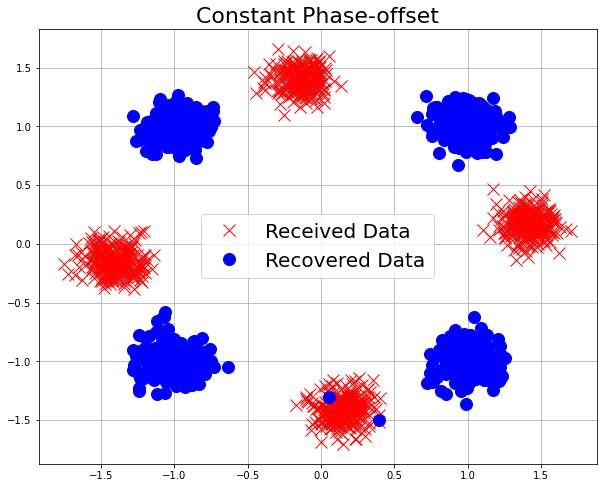

In [7]:
# Phase Offset and Data
phaseoffset=0.89 # Defining constant phase offset for this section of the project
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.707 # Damping factor \zeta

error1 = implement_costas(bw, M, df, phaseoffset, data)

### Question 2:
<br> Plot the phase error θ e for the Costas Loop. What do you observe and explain.
<br>
<br> *The plotted phase error appears to fluctuate between an amplitude of -0.4 to +0.4.*

In [8]:
# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error1)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

### Question 3:
<br> Repeat this experiment for ζ = 0.1, 1, and 2. Plot both the scatter plots and phase error curves. What do you observe and explain.
<br>
<br> *When the damping factor is at 0.1, the clusters have plots that are slightly scattered and the error convergence plot has significant fluctuations which is the result of the system being underdamped. Then, when the damping factor is at 1, the clusters in the scatter plot are more dense and its corresponding error convergence plot has a smaller fluctuation, resulting from the system being critically damped. Next, the damping factor is set at 2, where the system is overdamped and causes the clusters to be more scattered again.*

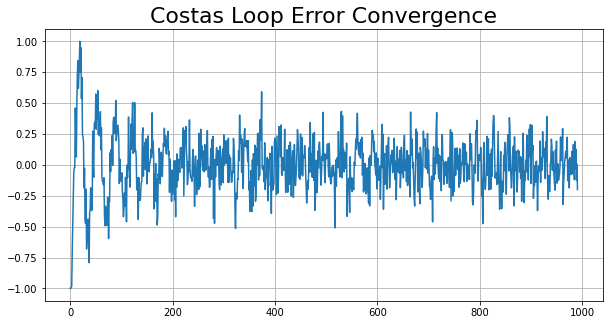

In [9]:
# ζ = 0.1

# Phase Offset and Data
phaseoffset=0.89 # Defining constant phase offset for this section of the project
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.1 # Damping factor \zeta

error2 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error2)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

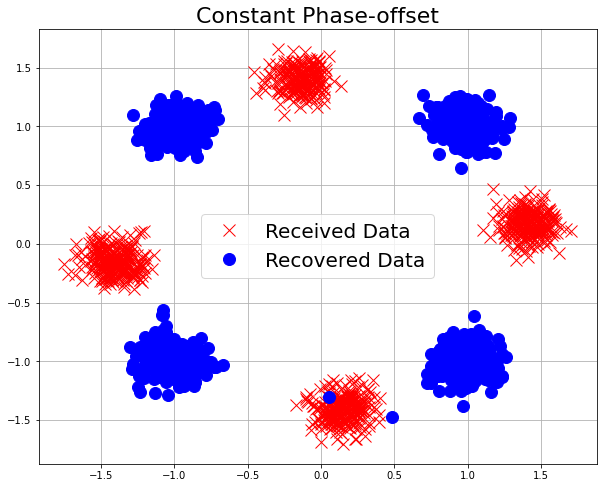

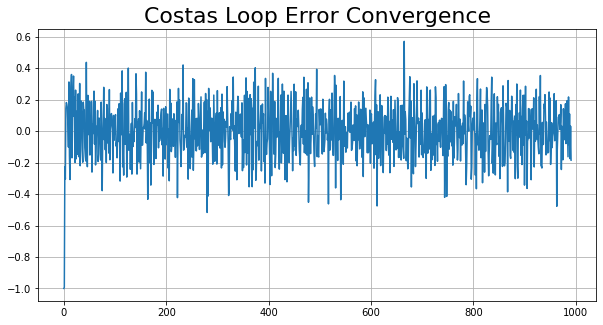

In [10]:
# ζ = 1

# Phase Offset and Data
phaseoffset=0.89 # Defining constant phase offset for this section of the project
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 1 # Damping factor \zeta

error3 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error3)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

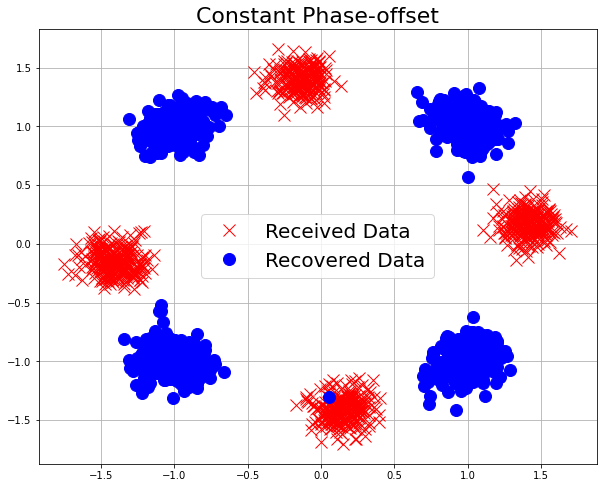

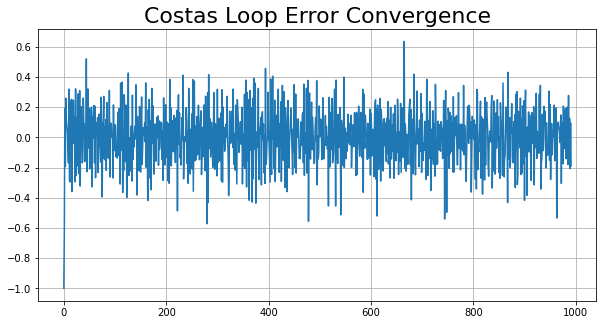

In [11]:
# ζ = 2

# Phase Offset and Data
phaseoffset=0.89 # Defining constant phase offset for this section of the project
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 2 # Damping factor \zeta

error4 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error4)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

### Question 4:
<br> Plot both the scatter plots and phase error curves for each of these three different phase offset functions. Explain your observations, especially if there are any scenarios where the Costas Loop loses lock and attempts to reacquire the signal.
<br>
<br> *The first time varying phase scenario includes a linearly increasing phase where the recovered data seems to be rotated clockwise from the received data. The second time varying phase scenario includes a unit step function where the recovered data clusters are between two received data clusters. Lastly, the third time varying phase scenario includes a sine function phase where the received data is found around the entire unit circle and the recovered data is condensed in the 4 quadrants.*

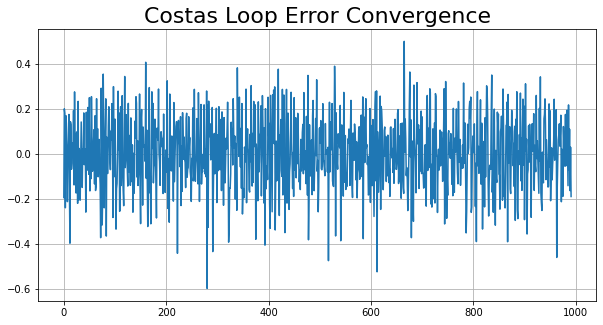

In [12]:
# Time-varying phase scenario 1: linearly increasing phase
phaseoffset=np.linspace(0, 0.85,len(QAM))
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.707 # Damping factor \zeta

error5 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error5)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

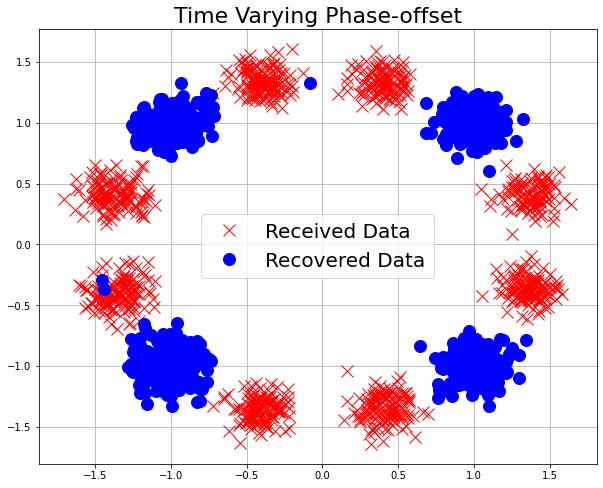

In [13]:
# Time-varying phase scenario 2: unit step function phase change
phaseoffset0 = [-0.5]*500
phaseoffset1 =[0.5]*500
phaseoffset = np.append(phaseoffset0, phaseoffset1, axis=0)
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.707 # Damping factor \zeta

error6 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error6)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

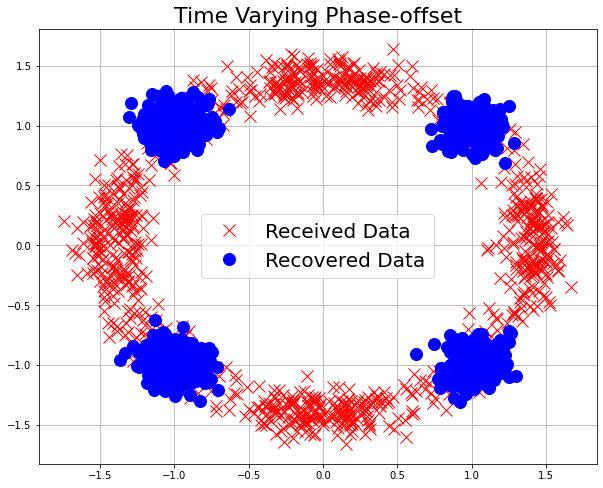

In [14]:
# Time-varying phase scenario 3: sine function phase variation
phaseoffset = np.sin(np.linspace(-np.pi,np.pi,len(QAM)))
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/100  # Loop bandwidth W_L
M = 4 # Modulation order (in this case, it is QPSK)
df = 0.707 # Damping factor \zeta

error7 = implement_costas(bw, M, df, phaseoffset, data)

# Phase error convergence plot
plt.figure(figsize=(10,5))
plt.plot(error7)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

### Question 5:
<br> Plot both the scatter plots for each of these three mystery files before and after the Costas Loop. Explain your observations. Also specify your choice of W L and ζ.
<br>
<br> *The 1st mystery signal is a QPSK that uses the a bandwidth of 2pi/35 and a damping factor of 1. The 2nd mystery signal is a BPSK that uses a bandwidth of 2pi/10 and a damping factor of 2. The 3rd mystery signal is an 8-PSK that uses the a bandwidth of 2pi/50 and a damping factor of 1*

In [15]:
def map_modulation(bps):
    # Generate the mapping from binary to complex baseband representations (graph signal constellation diagrams)
    total_symbols = 1000*bps
    if (bps == 1):          # BPSK
        mapping_table = {
            (0,) :  1+0j,
            (1,) : -1+0j
        }
    elif (bps == 2):        # QPSK
        mapping_table = {
            (1,0) : -1-1j,
            (1,1) : -1+1j,
            (0,0) :  1-1j,
            (0,1) :  1+1j
        }
    elif (bps == 3):        # 8PSK
        C = np.cos(np.pi/8)
        S = np.sin(np.pi/8)
        mapping_table = {
            (0,0,0) :  C+S*1j,
            (0,0,1) :  S+C*1j,
            (0,1,0) : -C+S*1j,
            (0,1,1) : -S+C*1j,
            (1,0,0) :  C-S*1j,
            (1,0,1) :  S-C*1j,
            (1,1,0) : -C-S*1j,
            (1,1,1) : -S+C*1j
        }

    # Generate binary data stream and map it to symbols
    bits = np.random.binomial(n=1, p=0.5, size=(total_symbols, ))
    def packing(bits):
        return bits.reshape((1000, bps))
    bits_packed = packing(bits)
    def Mapping(bits):
        return np.array([mapping_table[tuple(b)] for b in bits])
    QAM = Mapping(bits_packed)
    return QAM

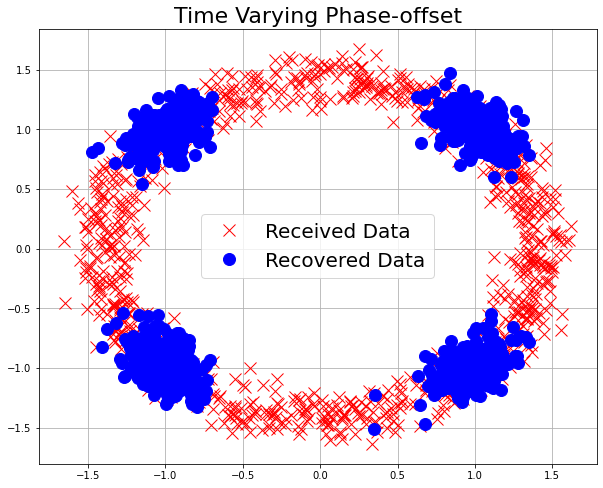

In [28]:
mysterysignal1=np.load('mysterysignal1.npy') # Load mystery signal 1 data from .npy file

# Mapping from binary to complex baseband representations
QAM = map_modulation(2)

# Phase Offset and Data
phaseoffset = np.linspace(0, len(mysterysignal1), len(QAM))
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/35  # Loop bandwidth W_L
M = 4 # Modulation order (2 for BPSK, 4 for QPSK, 8 for 8PSK)
df = 1 # Damping factor \zeta

error_msig1 = implement_costas(bw, M, df, phaseoffset, data)

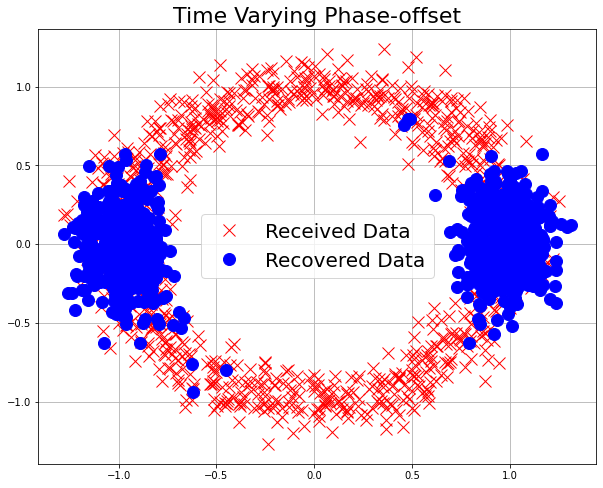

In [17]:
mysterysignal2=np.load('mysterysignal2.npy') # Load mystery signal 2 data from .npy file

# Mapping from binary to complex baseband representations
QAM = map_modulation(1)

# Phase Offset and Data 
phaseoffset = np.linspace(0, len(mysterysignal2), len(QAM))
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/10  # Loop bandwidth W_L
M = 2 # Modulation order (2 for BPSK, 4 for QPSK, 8 for 8PSK)
df = 2 # Damping factor \zeta

error_msig2 = implement_costas(bw, M, df, phaseoffset, data)

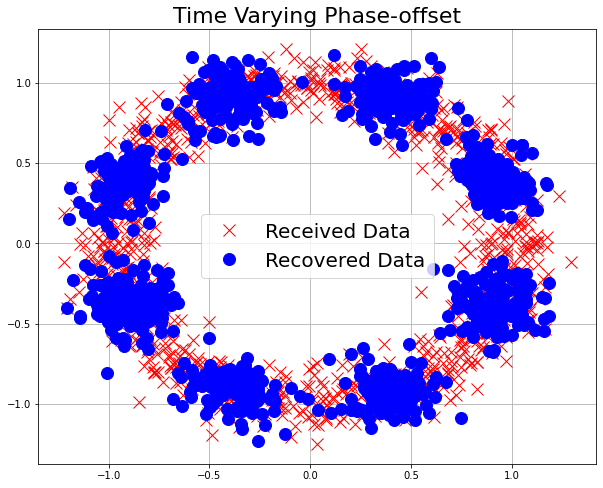

In [48]:
mysterysignal3=np.load('mysterysignal3.npy') # Load mystery signal 3 data from .npy file

# Mapping from binary to complex baseband representations
QAM = map_modulation(3)

# Phase Offset and Data
phaseoffset = np.linspace(0, len(mysterysignal3), len(QAM))
data = np.exp(1j*phaseoffset) * QAM

# Define Costas Loop parameters
bw = 2*np.pi/50  # Loop bandwidth W_L
M = 8 # Modulation order (2 for BPSK, 4 for QPSK, 8 for 8PSK)
df = 1 # Damping factor \zeta

error_msig3 = implement_costas(bw, M, df, phaseoffset, data)

### Question 6:
<br> Plot the phase error curves for each of these three different phase offset functions. Explain your observations.
<br>
<br> *The phase error curves for the three different phase offset functions fluctuate with approximately the same amplitude ranges.*

In [29]:
# Phase error convergence plot for the 1st mystery signal
plt.figure(figsize=(10,5))
plt.plot(error_msig1)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

In [20]:
# Phase error convergence plot for the 2nd mystery signal
plt.figure(figsize=(10,5))
plt.plot(error_msig2)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)

In [49]:
# Phase error convergence plot for the 3rd mystery signal
plt.figure(figsize=(10,5))
plt.plot(error_msig3)
plt.title('Costas Loop Error Convergence', fontsize=22)
plt.grid(True)